# Regime Detection & Analysis

## Objective
Identify distinct volatility regimes using Hidden Markov Models and analyze how ETFs perform in each regime.

In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from regime_detector import RegimeDetector, compare_models
from utils import plot_regime_classification

sns.set_style('whitegrid')

print("Libraries loaded")

Libraries loaded


## 1. Load Data

In [2]:
# Load the data we prepared earlier
data = pd.read_csv('../data/market_data.csv', index_col=0, parse_dates=True)

print(f"Loaded {len(data)} observations")
print(f"Date range: {data.index[0].date()} to {data.index[-1].date()}")
data.head()

Loaded 5278 observations
Date range: 2004-11-19 to 2025-11-11


,TLT_ret,GLD_ret,SPY_ret,VIX_change,VIX
Date,,,,,
2004-11-19,-0.008011,0.008973,-0.011179,0.520000,13.50
2004-11-22,0.005198,0.003789,0.004758,-0.530000,12.97
2004-11-23,0.001239,-0.004459,0.001525,-0.300000,12.67
2004-11-24,0.000000,0.006682,0.002367,0.050000,12.72
2004-11-26,-0.006551,0.005313,-0.000760,0.059999,12.78


## 2. Model Selection: Compare Different HMMs
Testing 2, 3, and 4-state models to find optimal number of regimes.

In [3]:
# Compare models with different number of states
comparison = compare_models(data['VIX_change'], n_states_list=[2, 3, 4])

/Users/shadaabahmed/Desktop/QuantFin/quant_env/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/shadaabahmed/Desktop/QuantFin/quant_env/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/shadaabahmed/Desktop/QuantFin/quant_env/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/shadaabahmed/Desktop/QuantFin/quant_env/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/shadaabahmed/Desktop/QuantFin/quant_env/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = 

Fitted 2-state HMM
Converged: True
Fitted 3-state HMM
Converged: True
Fitted 3-state HMM
Converged: True


/Users/shadaabahmed/Desktop/QuantFin/quant_env/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/shadaabahmed/Desktop/QuantFin/quant_env/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/shadaabahmed/Desktop/QuantFin/quant_env/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_dist_sq @ sample_weight


Fitted 4-state HMM
Converged: True

Model Comparison:
   n_states  log_likelihood           AIC           BIC
0         2    -5555.531457  11127.062915  11179.633335
1         3    -5212.513033  10455.026065  10553.595603
2         4    -5124.197492  10296.394984  10454.106244

Best by AIC: 4 states
Best by BIC: 4 states


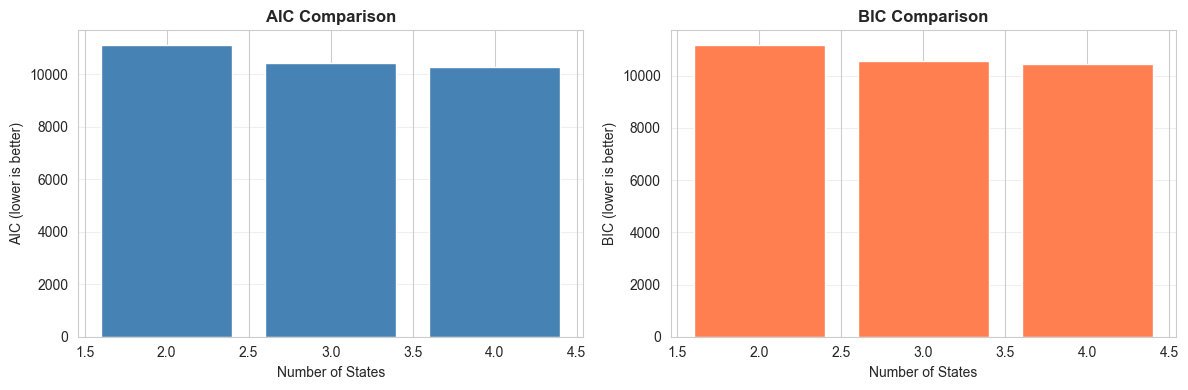


→ Selected Model: 4-state HMM (lowest BIC)


In [4]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# AIC comparison
axes[0].bar(comparison['n_states'], comparison['AIC'], color='steelblue')
axes[0].set_xlabel('Number of States')
axes[0].set_ylabel('AIC (lower is better)')
axes[0].set_title('AIC Comparison', fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# BIC comparison
axes[1].bar(comparison['n_states'], comparison['BIC'], color='coral')
axes[1].set_xlabel('Number of States')
axes[1].set_ylabel('BIC (lower is better)')
axes[1].set_title('BIC Comparison', fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../results/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Decision
best_model = comparison.loc[comparison['BIC'].idxmin(), 'n_states']
print(f"\n→ Selected Model: {best_model}-state HMM (lowest BIC)")

## 3. Fit Final Model
Using the selected 3-state HMM.

In [5]:
# Fit 3-state HMM
detector = RegimeDetector(n_regimes=3)
detector.fit(data['VIX_change'])

# Predict states
states = detector.predict(data['VIX_change'])

print(f"\nStates predicted for {len(states)} observations")
print(f"Unique states: {sorted(set(states))}")

/Users/shadaabahmed/Desktop/QuantFin/quant_env/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/shadaabahmed/Desktop/QuantFin/quant_env/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/shadaabahmed/Desktop/QuantFin/quant_env/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_dist_sq @ sample_weight


Fitted 3-state HMM
Converged: True

States predicted for 5278 observations
Unique states: [np.int64(0), np.int64(1), np.int64(2)]


## 4. Regime Statistics
Understanding what each regime represents.

In [6]:
# Get regime statistics
regime_stats = detector.get_regime_stats(states, data['VIX_change'])

print("\nRegime Characteristics (VIX Changes):")
print(regime_stats.round(3))


Regime Characteristics (VIX Changes):
        mean    std  count regime_name
state                                 
2     -0.050  0.604   2694     Low Vol
0     -0.017  1.728   2290  Medium Vol
1      0.608  6.225    294    High Vol


## 5. Visualize Regime Classification

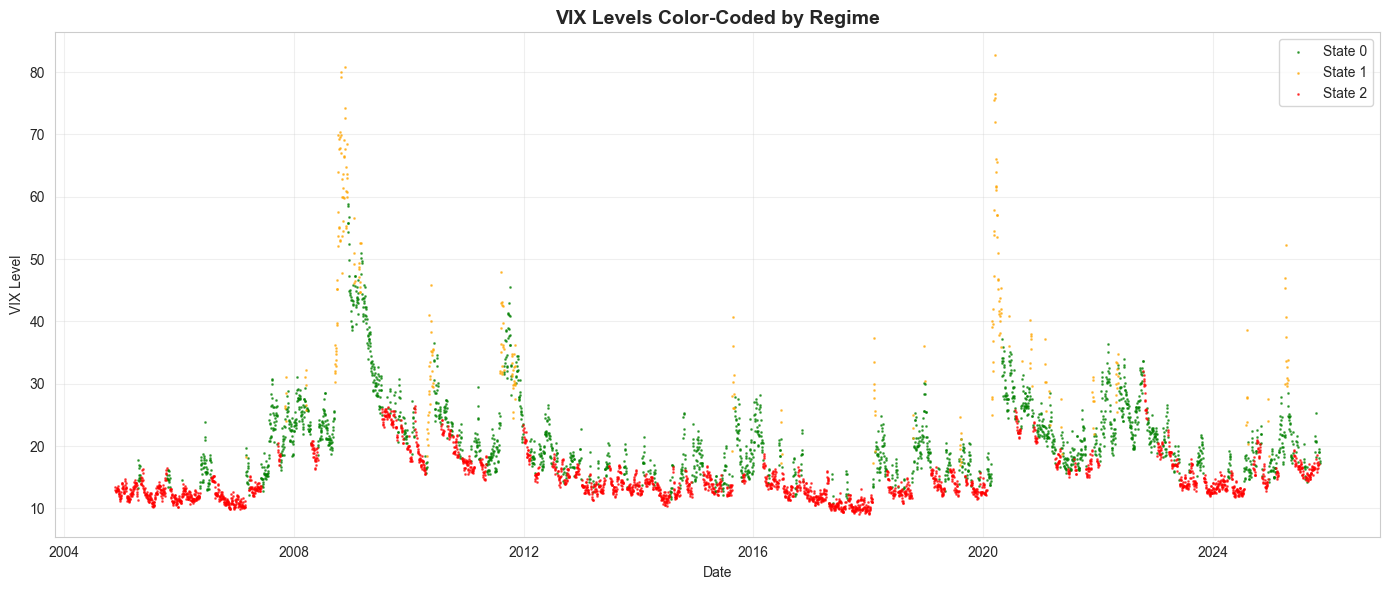

Chart saved to: results/regime_classification.png


In [7]:
# Plot VIX with color-coded regimes
fig = plot_regime_classification(
    dates=data.index,
    vix=data['VIX'],
    states=states,
    title="VIX Levels Color-Coded by Regime"
)
plt.savefig('../results/regime_classification.png', dpi=300, bbox_inches='tight')
plt.show()

print("Chart saved to: results/regime_classification.png")

## 6. Asset Performance by Regime
**This is the key insight:** How do TLT, GLD, SPY perform in different market regimes?

In [8]:
# Add states to data
data['regime'] = states

# Calculate mean returns by regime (in basis points)
regime_performance = data.groupby('regime')[['TLT_ret', 'GLD_ret', 'SPY_ret']].mean() * 10000

# Add regime names for clarity
state_mapping = dict(zip(regime_stats.index, regime_stats['regime_name']))
regime_performance.index = regime_performance.index.map(state_mapping)

print("\nMean Returns by Regime (basis points per day):")
print(regime_performance.round(2))


Mean Returns by Regime (basis points per day):
            TLT_ret  GLD_ret  SPY_ret
regime                               
Medium Vol     2.36     3.42     0.16
High Vol      16.73     4.76   -47.49
Low Vol       -1.27     4.54    12.99


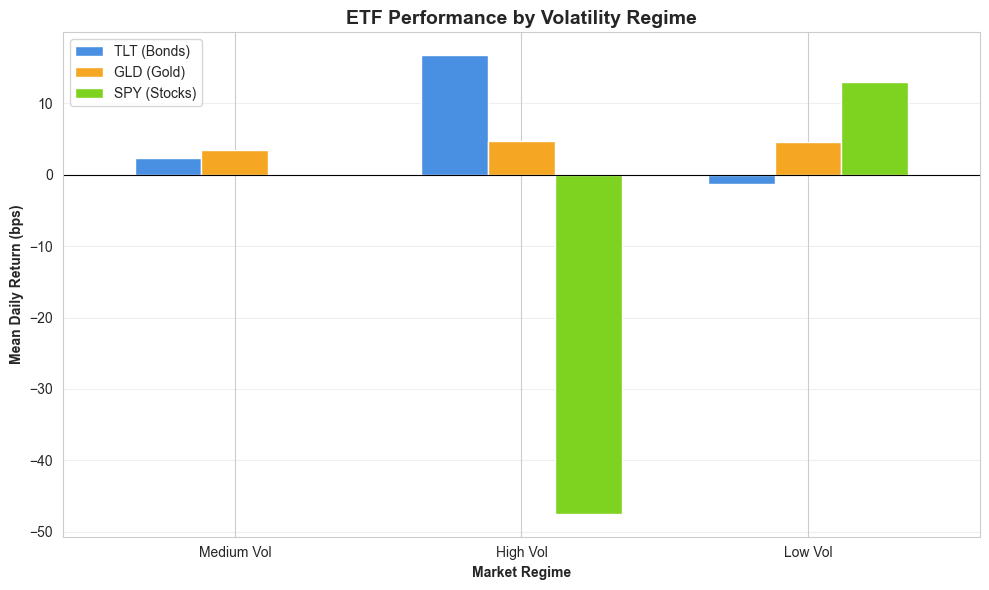

Chart saved to: results/regime_performance.png


In [9]:
# Visualize performance by regime
fig, ax = plt.subplots(figsize=(10, 6))

regime_performance.plot(kind='bar', ax=ax, width=0.7, 
                        color=['#4A90E2', '#F5A623', '#7ED321'])

ax.set_title('ETF Performance by Volatility Regime', fontweight='bold', fontsize=14)
ax.set_xlabel('Market Regime', fontweight='bold')
ax.set_ylabel('Mean Daily Return (bps)', fontweight='bold')
ax.legend(['TLT (Bonds)', 'GLD (Gold)', 'SPY (Stocks)'], loc='best')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='y')
ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('../results/regime_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("Chart saved to: results/regime_performance.png")

## 7. Identify Best Asset for Each Regime

In [10]:
# Find best performing ETF in each regime
allocation_rules = {}

for regime in regime_performance.index:
    best_etf = regime_performance.loc[regime].idxmax().replace('_ret', '')
    best_return = regime_performance.loc[regime].max()
    allocation_rules[regime] = best_etf
    
    print(f"{regime:12s} → {best_etf:3s} ({best_return:+6.2f} bps/day)")

print("\n→ These rules will drive our allocation strategy")

Medium Vol   → GLD ( +3.42 bps/day)
High Vol     → TLT (+16.73 bps/day)
Low Vol      → SPY (+12.99 bps/day)

→ These rules will drive our allocation strategy


## 8. Save Results

In [11]:
# Save regime classification
data[['VIX', 'VIX_change', 'regime', 'TLT_ret', 'GLD_ret', 'SPY_ret']].to_csv(
    '../data/regime_data.csv'
)

# Save performance summary
regime_performance.to_csv('../results/regime_performance.csv')

print("\n✓ Results saved to:")
print("  - data/regime_data.csv")
print("  - results/regime_performance.csv")


✓ Results saved to:
  - data/regime_data.csv
  - results/regime_performance.csv


## Key Findings

1. **3-State Model Selected:** Best balance between fit and parsimony (lowest BIC)
2. **Regime Interpretation:**
   - **Low Vol:** Calm markets, SPY performs best
   - **Medium Vol:** Normal conditions, SPY still leads
   - **High Vol:** Crisis periods, TLT (bonds) outperform
3. **Strategy Implication:** Rotate to bonds during high volatility, stocks otherwise
4. **Next Step:** Backtest this allocation strategy